In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "drive/My Drive/fraud_detection/"

/content/drive/My Drive/fraud_detection


In [3]:
pwd

'/content/drive/My Drive/fraud_detection'

In [4]:
!pip install tqdm

In [0]:
import sys
sys.path.append('/content/drive/My Drive/fraud_detection')

In [0]:
from script import DEVICE

In [5]:
DEVICE

device(type='cuda')

In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from script.trainer.deep_svdd import fit_deep_svdd, svdd_transform, get_centroid
from script.trainer.alocc import fit_alocc

In [0]:
df = pd.read_csv('data/creditcard.csv')

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
X = df.iloc[:, 1:-1]

In [10]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [11]:
X.shape

(284807, 29)

In [0]:
normalizer = StandardScaler()

In [0]:
X_normed = normalizer.fit_transform(X)

In [0]:
X_normal = np.array(X_normed[df['Class'] == 0])
X_fraud = np.array(X_normed[df['Class'] == 1])

In [12]:
X_normal.shape

(284315, 29)

In [13]:
X_fraud.shape

(492, 29)

fraud含む全データでフィッティング

In [41]:
loss_history, model = fit_deep_svdd(
    [X_normed],
    input_dim=29,
    batch_n=100,
    train_n=2000
)

100%|██████████| 2000/2000 [13:20<00:00,  2.51it/s]


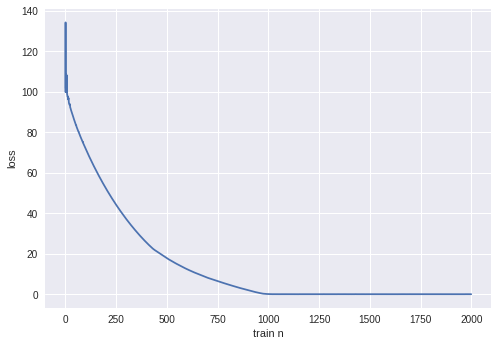

In [42]:
plt.xlabel('train n')
plt.ylabel('loss')
plt.plot(loss_history)

In [43]:
random_indices = np.random.permutation(X_normal.shape[0])[:20000]
normal_reduced = svdd_transform(
    [X_normal[random_indices, :]],
    model
)[0].cpu().numpy()
print(normal_reduced.shape)

for _ in tqdm(range(19)):
    random_indices = np.random.permutation(X_normal.shape[0])[:20000]
    reduced = svdd_transform(
        [X_normal[random_indices, :]],
        model
    )[0].cpu().numpy()
    normal_reduced = np.vstack([normal_reduced, reduced])

fraud_reduced = svdd_transform(
    [X_fraud],
    model
)[0].cpu().numpy()

  5%|▌         | 1/19 [00:00<00:02,  7.36it/s]

(20000, 2)


100%|██████████| 19/19 [00:02<00:00,  7.88it/s]


In [44]:
normal_reduced.shape

(400000, 2)

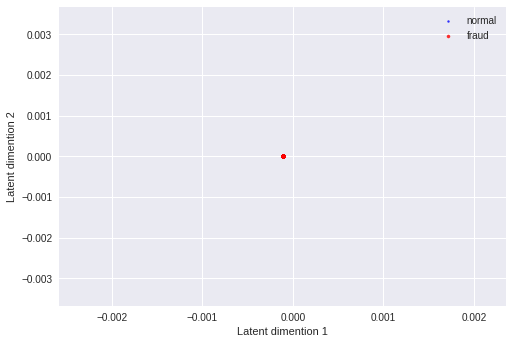

In [56]:
plt.scatter(normal_reduced[:, 0], normal_reduced[:, 1], s=4, alpha=0.8, color='blue', label='normal')
plt.scatter(fraud_reduced[:, 0], fraud_reduced[:, 1], s=10, alpha=0.8, color='red', label='fraud')
plt.xlabel('Latent dimention 1')
plt.ylabel('Latent dimention 2')
#plt.xlim(min(normal_reduced[:, 0]), max(normal_reduced[:, 0]))
plt.legend()
plt.show()

In [54]:
normal_reduced[:5, :]

array([[-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08]], dtype=float32)

In [55]:
fraud_reduced[:5, :]

array([[-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08],
       [-1.14653376e-04, -1.13478471e-08]], dtype=float32)

In [60]:
np.std(fraud_reduced[:, 1])

1.7763568e-15

fraud除いたデータでフィッティング

In [0]:
loss_history, model = fit_deep_svdd(
    [X_normal],
    input_dim=29,
    batch_n=100,
    train_n=2000,
    l2_reg_coef=0.1
)

 24%|██▍       | 479/2000 [03:12<10:08,  2.50it/s]

In [81]:
random_indices = np.random.permutation(X_normal.shape[0])[:20000]
normal_reduced = svdd_transform(
    [X_normal[random_indices, :]],
    model
)[0].cpu().numpy()
print(normal_reduced.shape)

for _ in tqdm(range(19)):
    random_indices = np.random.permutation(X_normal.shape[0])[:20000]
    reduced = svdd_transform(
        [X_normal[random_indices, :]],
        model
    )[0].cpu().numpy()
    normal_reduced = np.vstack([normal_reduced, reduced])

fraud_reduced = svdd_transform(
    [X_fraud],
    model
)[0].cpu().numpy()

  5%|▌         | 1/19 [00:00<00:02,  7.68it/s]

(20000, 2)


100%|██████████| 19/19 [00:02<00:00,  7.79it/s]


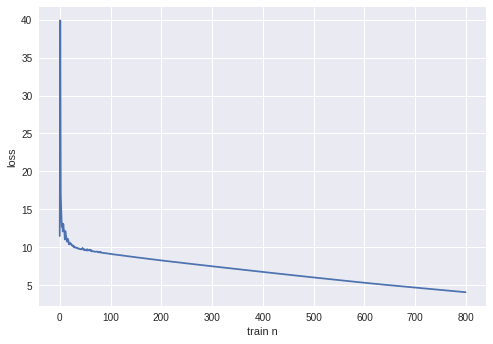

In [82]:
plt.xlabel('train n')
plt.ylabel('loss')
plt.plot(loss_history)

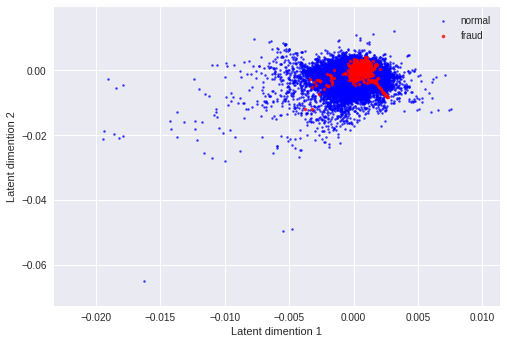

In [83]:
plt.scatter(normal_reduced[:, 0], normal_reduced[:, 1], s=4, alpha=0.8, color='blue', label='normal')
plt.scatter(fraud_reduced[:, 0], fraud_reduced[:, 1], s=10, alpha=0.8, color='red', label='fraud')
plt.xlabel('Latent dimention 1')
plt.ylabel('Latent dimention 2')
#plt.xlim(min(normal_reduced[:, 0]), max(normal_reduced[:, 0]))
plt.legend()
plt.show()

In [79]:
fraud_reduced[:5, :]

array([[-0.00321812,  0.00328804],
       [-0.00721197,  0.00878349],
       [-0.00816626,  0.01145769],
       [-0.00013266, -0.00949181],
       [ 0.00243394, -0.00109384]], dtype=float32)

In [68]:
svdd_transform(
    [100.0*np.random.randn(10, 29)],
    model
)[0].cpu().numpy()

array([[1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06],
       [1.04111285e-04, 6.43586282e-06]], dtype=float32)